# QAOA Cross-Validation Analysis: Multiple Train/Test Splits

This notebook demonstrates **cross-validation** analysis for QAOA parameter tuning across **10 different train/test splits**. Unlike the single-split analysis in `qaoa_demo.ipynb`, this notebook:

1. **Runs 10 independent train/test splits** (numbered run1 through run10)
2. **Aggregates results across all splits** to assess robustness and variability
3. **Visualizes performance and parameters** both aggregated and per-split
4. **Uses the cross_validation module** to handle multi-split data processing

## Purpose

Cross-validation helps answer:
- **How robust are parameter recommendations?** Do they work well across different train/test splits?
- **How variable is performance?** What's the spread in approximation ratios across splits?
- **Which strategy is most reliable?** TrainingStats vs TrainingResults across multiple splits

## Workflow Overview

1. Load data from 10 independent runs (each with its own train/test split)
2. Process and aggregate results across splits
3. Plot aggregated performance with confidence intervals
4. Examine individual split results for detailed analysis

In [1]:
%load_ext autoreload
%autoreload 2

## Import Modules and Packages

This notebook uses the **cross_validation module** (`cross_validation.py`) which provides specialized tools for aggregating results across multiple train/test splits.

### Key Imports:
- **cross_validation (cv)**: Handles loading and processing data from multiple split directories
- **plotting.ws_style**: Consistent matplotlib styling for publication-quality figures
- **pandas, numpy**: Data manipulation and numerical operations
- **matplotlib**: Visualization

In [2]:
# ============================================================
# Import Required Libraries
# ============================================================
import pandas as pd              # DataFrame operations
import matplotlib.pyplot as plt  # Plotting
import os                        # File path operations
import numpy as np               # Numerical operations
import sys

# Add src directory to Python path for importing stochastic_benchmark modules
sys.path.append('../../src/')

# Cross-validation module for handling multiple train/test splits
import cross_validation as cv

# Consistent plotting style for publication-quality figures
from plotting import ws_style
plt.style.use(ws_style)

In [3]:
# ============================================================
# Algorithm Parameters to Track
# ============================================================
# These are the QAOA parameters that were tuned in each run
parameter_names = ['iterations', 'shots', 'rounds']

# ============================================================
# Cross-Validation Setup: 10 Independent Train/Test Splits
# ============================================================
# Each "run" represents an independent train/test split of the problem instances
# Split indices go from 1 to 10 (run1, run2, ..., run10)
curpath = os.path.abspath('.')
folders = [
    os.path.join(curpath, 'runs', f'run{split}', 'checkpoints') 
    for split in range(1, 11)  # 10 splits total
]

# ============================================================
# Experiments to Analyze
# ============================================================
# Which parameter recommendation strategies to compare across splits
list_of_expts = [
    'Projection from TrainingStats',   # Aggregate-then-recommend strategy
    'Projection from TrainingResults'  # Instance-specific-then-average strategy
]

# ============================================================
# Visualization Configuration
# ============================================================
# Color mapping for consistent plotting across all figures
colors_dict = {
    'baseline': 'k',                              # Virtual Best (black)
    'Projection from TrainingStats': 'tab:blue',  # TrainingStats (blue)
    'Projection from TrainingResults': 'tab:orange',  # TrainingResults (orange)
    'Random Exploration': 'green',                 # (if present)
    'SequentialSearch: Id=cold': 'red',           # (if present)
    'SequentialSearch: Id=warm': 'purple'         # (if present)
}

# Axis labels with mathematical notation
response_string = (
    'Approximation Ratio\n' + 
    r"r=$\frac{\langle \vec{\beta}, \vec{\gamma} | H | \vec{\beta}, \vec{\gamma} \rangle}{E_{max}}$"
)
resource_string = r'Resource = Restarts $\times$ shots $\times$ COBYLA Iterations'

## Configuration: Cross-Validation Setup

This cell configures the cross-validation analysis by specifying:

1. **Parameter names** to track across splits (iterations, shots, rounds)
2. **Data directories** for the 10 independent runs (run1 through run10)
3. **Experiments to analyze** (projection strategies)
4. **Visualization settings** (colors, axis labels)

### Directory Structure

Each run directory (`runs/run1/`, `runs/run2/`, ..., `runs/run10/`) contains:
- `checkpoints/performance_plotting/`: Performance CSVs for each experiment
- `checkpoints/params_plotting/`: Parameter recommendation CSVs

The cross_validation module will load data from all these directories and aggregate results.

In [4]:
# ============================================================
# Load Parameter Data from All Splits
# ============================================================
# Reads CSV files from checkpoints/params_plotting/ for each split
# - Loads baseline (Virtual Best) and projection experiments
# - Concatenates data across all 10 splits
# - Stores in cv.parameters_dict[experiment_name]
print("Loading parameter data from all splits...")
try:
    cv.load_parameters(folders, list_of_expts)
    print(f"Loaded parameter data for {len(cv.parameters_dict)} experiments")
except Exception as e:
    print(f"Warning: Error loading parameter data: {e}")
    print("Continuing with available data...")

# Aggregate parameter data across splits
# - Computes mean parameter values across splits
# - Calculates confidence intervals
# - Stores in cv.parameters_summarized_dict[experiment][parameter]
if len(cv.parameters_dict) > 0:
    print("Aggregating parameter data across splits...")
    try:
        cv.process_params_across_splits(parameter_names)
        print("Aggregated parameters across splits")
    except Exception as e:
        print(f"Warning: Error aggregating parameters: {e}")
else:
    print("Warning: No parameter data loaded - skipping aggregation")

# ============================================================
# Load Performance Data from All Splits  
# ============================================================
# Reads CSV files from checkpoints/performance_plotting/ for each split
# - Loads baseline and projection experiments
# - Option to interpolate to common resource grid (disabled if causing issues)
# - Stores in cv.performance_dict[experiment_name]
print("\nLoading performance data from all splits...")
try:
    # Try with interpolation disabled first (more robust)
    cv.load_performance(
        folders, 
        list_of_expts,
        interpolate_flag=False  # Disable interpolation to avoid errors with missing data
    )
    print(f"Loaded performance data for {len(cv.performance_dict)} experiments")
except Exception as e:
    print(f"Warning: Error loading performance data: {e}")
    print("Continuing with available data...")

# Aggregate performance data across splits
# - Computes mean approximation ratio across splits
# - Calculates confidence intervals  
# - Stores in cv.performance_summarized_dict[experiment]
if len(cv.performance_dict) > 0:
    print("Aggregating performance data across splits...")
    try:
        cv.process_performance_across_splits(parameter_names)
        print("Aggregated performance across splits")
    except Exception as e:
        print(f"Warning: Error aggregating performance: {e}")
else:
    print("Warning: No performance data loaded - skipping aggregation")

print("\n" + "=" * 60)
print("DATA LOADING SUMMARY")
print("=" * 60)
print(f"Experiments with parameter data: {list(cv.parameters_dict.keys())}")
print(f"Experiments with performance data: {list(cv.performance_dict.keys())}")
print(f"Number of splits configured: {len(folders)}")
print("=" * 60)

Loading parameter data from all splits...
Loaded parameter data for 3 experiments
Aggregating parameter data across splits...
Aggregated parameters across splits

Loading performance data from all splits...
Loaded performance data for 3 experiments
Aggregating performance data across splits...

DATA LOADING SUMMARY
Experiments with parameter data: ['baseline', 'Projection from TrainingStats', 'Projection from TrainingResults']
Experiments with performance data: ['baseline', 'Projection from TrainingStats', 'Projection from TrainingResults']
Number of splits configured: 10
Loaded performance data for 3 experiments
Aggregating performance data across splits...

DATA LOADING SUMMARY
Experiments with parameter data: ['baseline', 'Projection from TrainingStats', 'Projection from TrainingResults']
Experiments with performance data: ['baseline', 'Projection from TrainingStats', 'Projection from TrainingResults']
Number of splits configured: 10


## Load and Process Cross-Validation Data

This section loads results from all 10 train/test splits and aggregates them for analysis.

### Optional: Check Data Availability First

The cell below can be run to verify which data files exist before attempting to load them. This is useful for:
- **Debugging**: Understanding why loading might fail
- **Validation**: Ensuring all expected experiments have been completed
- **Planning**: Identifying which splits or experiments need to be re-run

**You can skip this cell if you're confident all data files exist.**

### Data Loading Process

**For Parameters:**
1. `cv.load_parameters()` - Loads parameter CSV files from each split's `checkpoints/params_plotting/` directory
2. `cv.process_params_across_splits()` - Aggregates across splits, computing mean and confidence intervals

**For Performance:**
1. `cv.load_performance()` - Loads performance CSV files from each split's `checkpoints/performance_plotting/` directory
2. `cv.process_performance_across_splits()` - Aggregates across splits, computing mean and confidence intervals

### Output Data Structures

After processing, the following dictionaries are populated:
- `cv.parameters_dict[expt]` - Raw parameter data for each experiment across all splits
- `cv.parameters_summarized_dict[expt][param]` - Aggregated statistics (mean, CI_lower, CI_upper) for each parameter
- `cv.performance_dict[expt]` - Raw performance data for each experiment across all splits  
- `cv.performance_summarized_dict[expt]` - Aggregated performance statistics (mean, CI_lower, CI_upper)

**Note:** If any CSV files are missing, warnings will be displayed but processing will continue with available data.

In [5]:
# ============================================================
# Check Data Availability (Optional - for debugging)
# ============================================================
# Verify which data files actually exist before attempting to load
print("Checking data availability across splits...\n")

experiments_to_check = ['baseline'] + list_of_expts
data_types = ['params_plotting', 'performance_plotting']

# Track availability statistics
availability_stats = {
    'total_splits': len(folders),
    'existing_folders': 0,
    'params_available': {expt: 0 for expt in experiments_to_check},
    'performance_available': {expt: 0 for expt in experiments_to_check}
}

for split_idx, folder in enumerate(folders):
    print(f"Split {split_idx + 1} ({os.path.basename(os.path.dirname(folder))}):")
    
    # Check if checkpoints folder exists
    if not os.path.exists(folder):
        print(f"  [MISSING] Checkpoints folder: {folder}")
        continue
    
    availability_stats['existing_folders'] += 1
    
    # Check each data type
    for data_type in data_types:
        data_dir = os.path.join(folder, data_type)
        if os.path.exists(data_dir):
            # List available CSV files
            csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
            print(f"  {data_type}: {len(csv_files)} files")
            
            # Check which experiments have files
            for expt in experiments_to_check:
                expected_file = os.path.join(data_dir, f"{expt}.csv")
                if os.path.exists(expected_file):
                    print(f"    [OK] {expt}.csv")
                    # Track availability
                    if data_type == 'params_plotting':
                        availability_stats['params_available'][expt] += 1
                    else:
                        availability_stats['performance_available'][expt] += 1
                else:
                    print(f"    [MISSING] {expt}.csv")
        else:
            print(f"  [MISSING] {data_type} directory")
    print()

# Print summary statistics
print("=" * 60)
print("DATA AVAILABILITY SUMMARY")
print("=" * 60)
print(f"Checkpoint folders found: {availability_stats['existing_folders']}/{availability_stats['total_splits']}")
print()

print("Parameter data availability:")
for expt, count in availability_stats['params_available'].items():
    status = "[COMPLETE]" if count == availability_stats['total_splits'] else "[INCOMPLETE]"
    print(f"  {status} {expt}: {count}/{availability_stats['total_splits']} splits")

print()
print("Performance data availability:")
for expt, count in availability_stats['performance_available'].items():
    status = "[COMPLETE]" if count == availability_stats['total_splits'] else "[INCOMPLETE]"
    print(f"  {status} {expt}: {count}/{availability_stats['total_splits']} splits")

print("=" * 60)

Checking data availability across splits...

Split 1 (run1):
  params_plotting: 3 files
    [OK] baseline.csv
    [OK] Projection from TrainingStats.csv
    [OK] Projection from TrainingResults.csv
  performance_plotting: 3 files
    [OK] baseline.csv
    [OK] Projection from TrainingStats.csv
    [OK] Projection from TrainingResults.csv

Split 2 (run2):
  params_plotting: 3 files
    [OK] baseline.csv
    [OK] Projection from TrainingStats.csv
    [OK] Projection from TrainingResults.csv
  performance_plotting: 3 files
    [OK] baseline.csv
    [OK] Projection from TrainingStats.csv
    [OK] Projection from TrainingResults.csv

Split 3 (run3):
  params_plotting: 3 files
    [OK] baseline.csv
    [OK] Projection from TrainingStats.csv
    [OK] Projection from TrainingResults.csv
  performance_plotting: 3 files
    [OK] baseline.csv
    [OK] Projection from TrainingStats.csv
    [OK] Projection from TrainingResults.csv

Split 4 (run4):
  params_plotting: 3 files
    [OK] baseline.csv
  

## Aggregated Parameter Plots Across All Splits

These plots show how **parameter recommendations** evolve with resources, **aggregated across all 10 train/test splits**.

### What This Shows:

For each algorithm parameter (iterations, shots, rounds):
- **Mean parameter values** across all splits at each resource level
- **Confidence intervals** (shaded regions) showing variability across splits
- **Virtual Best** (black) vs **Projection strategies** (colored)

### Interpreting Confidence Intervals:

- **Narrow intervals**: Parameter recommendations are consistent across different train/test splits (robust)
- **Wide intervals**: Recommendations vary significantly depending on which instances are in train vs test sets (less robust)

The plots help assess whether parameter recommendations are stable or sensitive to the particular train/test split.

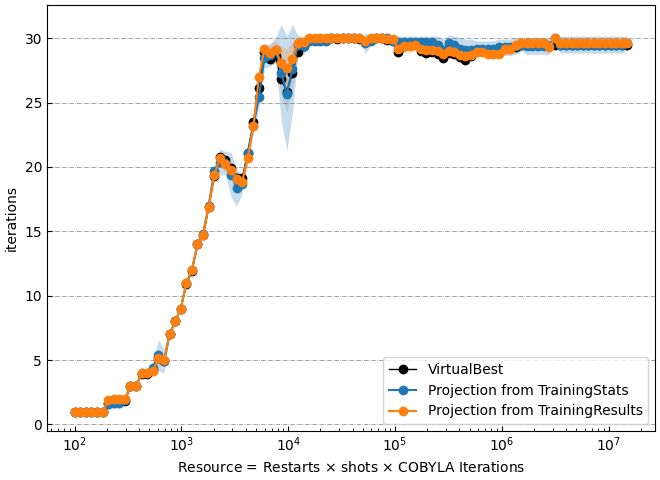

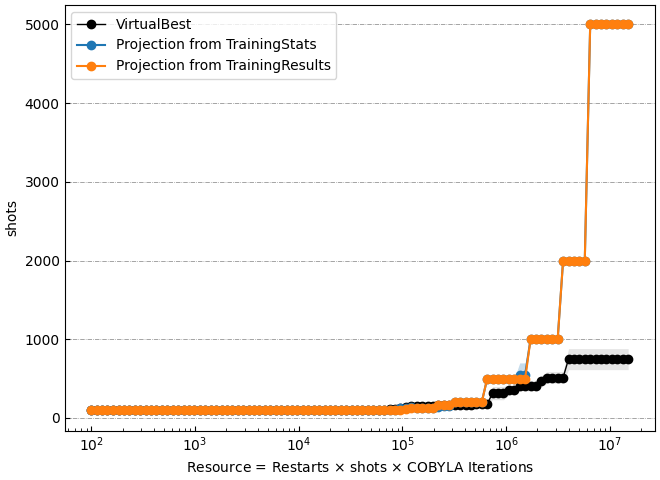

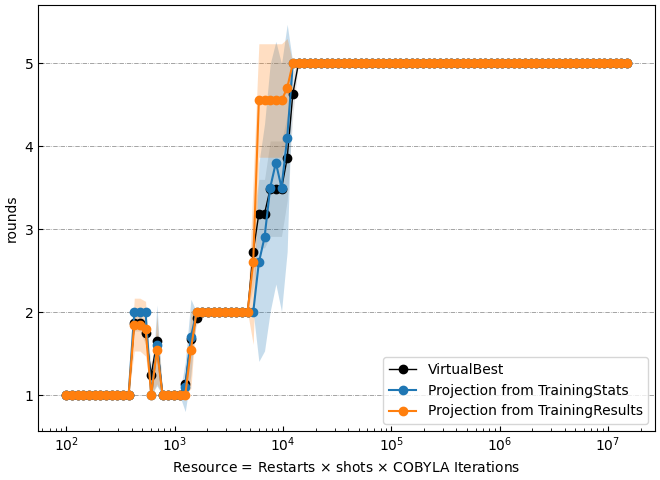

In [6]:
# ============================================================
# Plot Aggregated Parameters Across All Splits
# ============================================================
# Creates one plot per parameter showing mean and confidence intervals
# aggregated across all 10 train/test splits

for param in parameter_names:
    fig, axs = plt.subplots()
    
    # Plot each experiment's aggregated parameter values
    for expt in cv.parameters_summarized_dict.keys():
        expt_param_df = cv.parameters_summarized_dict[expt][param]
        
        # Extract mean and confidence interval bounds
        y = expt_param_df['mean']
        x = expt_param_df['resource']
        y_u = expt_param_df['CI_u']
        y_l = expt_param_df['CI_l']
        
        # Style configuration
        if expt == 'baseline':
            lw = 1
            alpha = 0.1
            label = 'VirtualBest'
        else:
            lw = 1.5
            alpha = 0.25
            label = expt
        
        # Plot confidence interval and mean line
        axs.fill_between(x, y_l, y_u, alpha=alpha, lw=0, color=colors_dict[expt])
        axs.plot(x, y, '-o', lw=lw, color=colors_dict[expt], label=label)
    
    # Configure axes and styling
    axs.set_xscale('log')
    axs.set_xlabel(resource_string)
    axs.set_ylabel(param)
    axs.grid(axis="y")
    axs.set_axisbelow(True)
    axs.legend(loc='best')
    fig.tight_layout()
    
    # Optionally save figures (commented out by default)
    # figsaveloc = os.path.join('figures', 'all_splits')
    # if not os.path.exists(figsaveloc): 
    #     os.makedirs(figsaveloc)
    # figname = os.path.join(figsaveloc, param)
    # fig.savefig(figname + '.png', dpi=300)
    # fig.savefig(figname + '.pdf')

## Aggregated Performance Plot Across All Splits

This plot shows the **approximation ratio** (performance metric) aggregated across all 10 train/test splits.

### What This Shows:

- **Mean approximation ratio** at each resource level, averaged across all splits
- **Confidence intervals** (shaded regions) showing performance variability across splits
- **Virtual Best** (black): Oracle baseline using perfect hindsight
- **Projection strategies** (colored): Different parameter recommendation approaches

### Key Insights:

- **Convergence to Virtual Best**: How close do the strategies get to optimal performance?
- **Consistency across splits**: Narrow confidence intervals indicate reliable performance regardless of train/test split
- **Resource efficiency**: Which strategy achieves good performance with fewer resources?

This is the primary plot for comparing the effectiveness of different parameter recommendation strategies in a cross-validation setting.

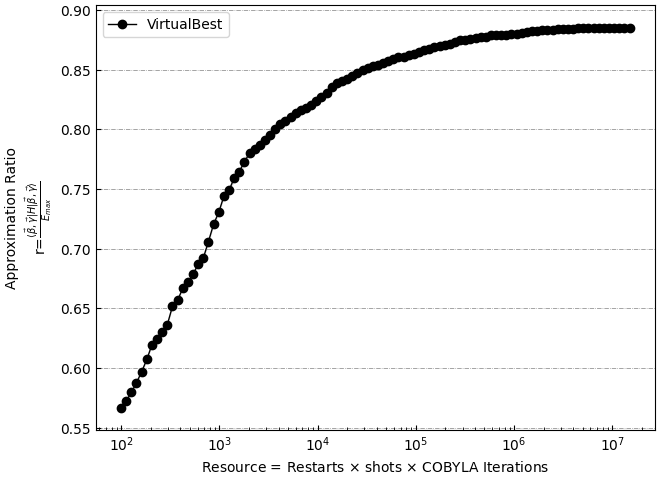

In [7]:
# ============================================================
# Plot Aggregated Performance Across All Splits
# ============================================================
# Shows mean approximation ratio and confidence intervals
# aggregated across all 10 train/test splits

fig, axs = plt.subplots()

# Plot each experiment's aggregated performance
for expt, expt_df in cv.performance_summarized_dict.items():
    # Extract mean and confidence interval bounds
    x = expt_df['resource']
    y = expt_df['mean']
    y_u = expt_df['CI_u']
    y_l = expt_df['CI_l']
    
    # Style configuration based on experiment type
    if expt == 'baseline':
        lw = 1
        alpha = 0.1
        label = 'VirtualBest'
    else:
        lw = 1.5
        alpha = 0.25
        label = expt
    
    # Plot confidence interval and mean line
    axs.fill_between(x, y_l, y_u, alpha=alpha, lw=0, color=colors_dict[expt])
    axs.plot(x, y, '-o', lw=lw, color=colors_dict[expt], label=label)

# Configure axes and styling
axs.set_xscale('log')
axs.set_xlabel(resource_string)
axs.set_ylabel(response_string)
axs.grid(axis="y")
axs.set_axisbelow(True)
axs.legend(loc='best')
fig.tight_layout()

# Optionally save figure (commented out by default)
# figsaveloc = os.path.join('figures', 'all_splits')
# if not os.path.exists(figsaveloc): 
#     os.makedirs(figsaveloc)
# figname = os.path.join(figsaveloc, 'performance')
# fig.savefig(figname + '.png', dpi=300)
# fig.savefig(figname + '.pdf')

## Individual Split Analysis

While aggregated plots show overall trends, examining **individual splits** can reveal:
- **Outlier splits**: Which train/test splits behave differently?
- **Split-specific patterns**: Are some splits easier/harder than others?
- **Recommendation stability**: Do parameter recommendations vary wildly between splits?

### How to Use This Section:

1. **Select a split**: Change `split_ind` to examine different splits (0-9 for run1-run10)
2. **Compare to aggregated plots**: How does this split compare to the mean behavior?
3. **Look for anomalies**: Unusually wide gaps or different convergence patterns

This detailed view helps understand what contributes to the confidence intervals in the aggregated plots.

In [8]:
# ============================================================
# Select Split to Examine
# ============================================================
# split_ind ranges from 0 to 9, corresponding to run1 through run10
# Change this value to examine different train/test splits
split_ind = 0  # Examine run1 (first split)

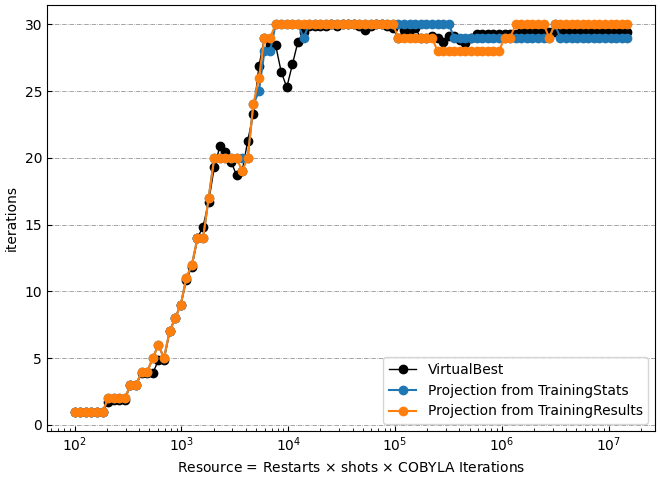

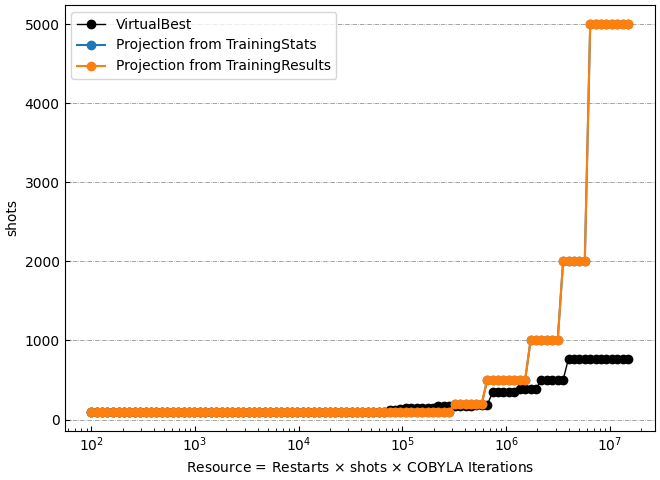

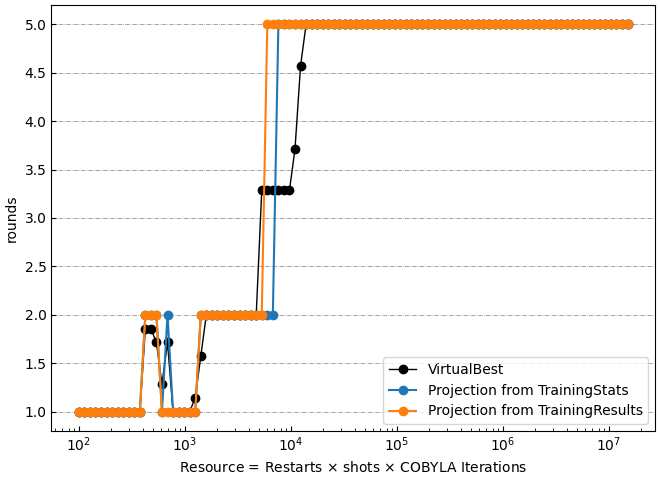

In [9]:
# ============================================================
# Plot Parameters for Selected Split
# ============================================================
# Shows parameter recommendations for a single train/test split
# Compare to aggregated plots to see split-specific variations

for param in parameter_names:
    fig, axs = plt.subplots()
    
    # Plot each experiment's parameter values for this split
    for expt, expt_df in cv.parameters_dict.items():
        # Filter data for selected split
        expt_split_df = expt_df[expt_df['split_ind'] == split_ind]
        x = expt_split_df['resource']
        y = expt_split_df[param]
        
        # Style configuration
        if expt == 'baseline':
            lw = 1
            label = 'VirtualBest'
        else:
            lw = 1.5
            label = expt
        
        # Plot parameter trajectory
        axs.plot(x, y, '-o', lw=lw, color=colors_dict[expt], label=label)
    
    # Configure axes and styling
    axs.set_xscale('log')
    axs.set_xlabel(resource_string)
    axs.set_ylabel(param)
    axs.grid(axis="y")
    axs.set_axisbelow(True)
    axs.legend(loc='best')
    fig.tight_layout()
    
    # Optionally save figures (commented out by default)
    # figsaveloc = os.path.join('figures', f'split_ind={split_ind}')
    # if not os.path.exists(figsaveloc): 
    #     os.makedirs(figsaveloc)
    # figname = os.path.join(figsaveloc, param)
    # fig.savefig(figname + '.png', dpi=300)
    # fig.savefig(figname + '.pdf')

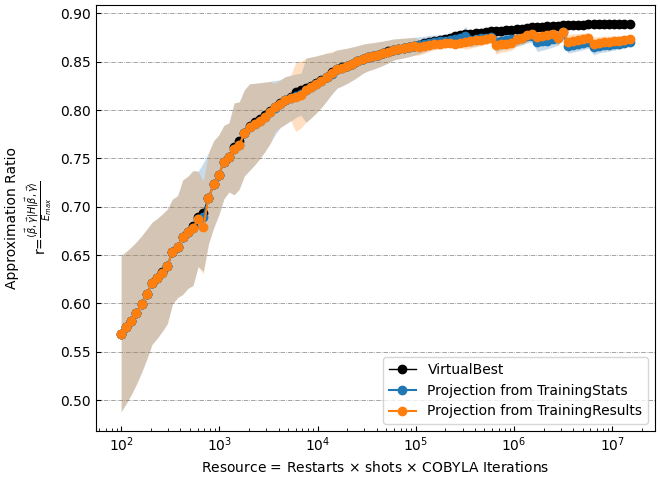

In [10]:
# ============================================================
# Plot Performance for Selected Split
# ============================================================
# Shows approximation ratio for a single train/test split
# Individual split CIs (if present) show bootstrap uncertainty within that split

fig, axs = plt.subplots()

# Plot each experiment's performance for this split
for expt, expt_df in cv.performance_dict.items():
    # Filter data for selected split
    expt_split_df = expt_df[expt_df['split_ind'] == split_ind]
    y = expt_split_df['response']
    x = expt_split_df['resource']
    
    # Style configuration
    if expt == 'baseline':
        lw = 1
        alpha = 0.1
        label = 'VirtualBest'
    else:
        lw = 1.5
        alpha = 0.25
        label = expt
    
    # Plot performance trajectory
    axs.plot(x, y, '-o', lw=lw, color=colors_dict[expt], label=label)
    
    # Add confidence intervals if available (bootstrap CIs within this split)
    if 'response_lower' in expt_split_df.columns:
        y_u = expt_split_df['response_upper']
        y_l = expt_split_df['response_lower']
        axs.fill_between(x, y_l, y_u, alpha=alpha, lw=0, color=colors_dict[expt])

# Configure axes and styling
axs.set_xscale('log')
axs.set_xlabel(resource_string)
axs.set_ylabel(response_string)
axs.grid(axis="y")
axs.set_axisbelow(True)
axs.legend(loc='best')
fig.tight_layout()

# Optionally save figure (commented out by default)
# figsaveloc = os.path.join('figures', f'split_ind={split_ind}')
# if not os.path.exists(figsaveloc): 
#     os.makedirs(figsaveloc)
# figname = os.path.join(figsaveloc, 'performance')
# fig.savefig(figname + '.png', dpi=300)
# fig.savefig(figname + '.pdf')

## Conclusions and Next Steps

This notebook demonstrated a comprehensive **cross-validation analysis** of QAOA parameter tuning strategies across 10 independent train/test splits.

### Key Takeaways:

1. **Robustness Assessment**: The confidence intervals in aggregated plots reveal how sensitive each strategy is to the particular train/test split
   - **Narrow confidence intervals** → Strategy produces consistent recommendations regardless of which instances are in train vs test
   - **Wide confidence intervals** → Recommendations vary significantly with different splits (potential overfitting to training data)

2. **Performance Comparison**: The aggregated performance plot shows:
   - How close each strategy gets to the Virtual Best (oracle) performance
   - Resource efficiency: Which strategy achieves good performance with fewer function evaluations
   - Reliability: Whether performance is consistent across all splits

3. **Individual Split Insights**: Examining individual splits helps:
   - Identify outlier splits that may have unusual characteristics
   - Understand the sources of variability in the aggregated results
   - Debug unexpected behavior in the overall analysis

### Interpreting Your Results:

- **Best strategy**: Look for approaches that combine:
  - High mean approximation ratio (close to Virtual Best)
  - Narrow confidence intervals (robust across splits)
  - Good resource efficiency (high performance with fewer resources)

- **Trade-offs**: Consider the balance between:
  - **TrainingStats** (aggregate-then-recommend): May have lower variance but potentially lower peak performance
  - **TrainingResults** (instance-specific-then-average): May achieve higher peak performance but with more variability

### Recommendations:

- If confidence intervals are wide, consider:
  - Using more training instances to reduce variance
  - Adjusting the parameter search space
  - Testing alternative recommendation strategies

- If performance doesn't converge to Virtual Best:
  - Check if resource budgets are sufficient
  - Verify that the parameter space includes optimal values
  - Consider whether the problem instances are too diverse for a single recommendation

### Next Steps:

1. **Compare to single-split results** in `qaoa_demo.ipynb` to see if cross-validation reveals different insights
2. **Adjust strategies** based on the robustness/performance trade-offs observed
3. **Re-run experiments** for splits with incomplete data (check data availability cell)
4. **Test on new problem instances** using the recommended parameters from the most robust strategy